In [4]:
import tensorflow as tf
from tensorflow.keras import layers, models

In [5]:
def inception_module(x, f1, f3r, f3, f5r, f5, proj):
  # 1 * 1 Convolution branch
  conv1 = layers.Conv2D(f1, (1, 1), padding='same', activation='relu')(x)

  # 1*1 -> 3*3
  conv3 = layers.Conv2D(f3r, (1, 1), padding='same', activation='relu')(x)
  conv3 = layers.Conv2D(f3, (3, 3), padding='same', activation='relu')(conv3)

  # 1*1 -> 5*5
  conv5 = layers.Conv2D(f5r, (1, 1), padding='same', activation='relu')(x)
  conv5 = layers.Conv2D(f5, (5, 5), padding='same', activation='relu')(conv5)

  # 3*3 max pooling -> 1*1 convolutinal
  pool = layers.MaxPool2D((3, 3), strides=(1, 1), padding='same')(x)
  pool = layers.Conv2D(proj, (1, 1), padding='same', activation='relu')(pool)

  # concatenate all branches along the axis
  output = layers.concatenate([conv1, conv3, conv5, pool], axis=-1)
  return output

In [6]:
def auxilary_classifier(x,num_classes):
  # 5*5 Avarage Pooling with stride 3
  x = layers.AveragePooling2D((5, 5), strides=(3, 3))(x)

  # 1*1 Convolution with 128 filters
  x = layers.Conv2D(128, (1, 1), padding='same',activation='relu')(x)

  # Flatten & fully connected
  x = layers.Flatten()(x)
  x = layers.Dense(1024, activation='relu')(x)

  # Dropout 70%
  x = layers.Dropout(0.7)(x)

  # Output layer with softmax activation
  x = layers.Dense(num_classes, activation='softmax')(x)

  return layers.Dense(num_classes, activation='softmax')(x)

In [7]:
def GoogLeNet(input_shape = (224,224,3), num_classes=1000):
  input_layer = layers.Input(shape=input_shape)

  # Initial Convplution and Pooling layers (stem)
  x = layers.Conv2D(64, (7, 7), strides=(2, 2), padding='same', activation='relu')(input_layer)
  x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

  x = layers.Conv2D(64, (1, 1), strides=(1, 1), activation='relu')(x)
  x = layers.Conv2D(192, (3, 3), strides=(1, 1), padding='same', activation='relu')(x)
  x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

  # Inception (3a) and (3b)
  x = inception_module(x, 64, 96, 128, 16, 32, 32)
  x = inception_module(x, 128, 128, 192, 32, 96, 64)

  # Max Pooling
  x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

  # Inception (4a) + Auxilary Classifier 1
  x = inception_module(x, 192, 96, 208, 16, 48, 64)
  aux1 = auxilary_classifier(x,num_classes)

  # Inception (4b) - (4d)
  x = inception_module(x, 160, 112, 224, 24, 64, 64)
  x = inception_module(x, 128, 128, 256, 24, 64, 64)
  x = inception_module(x, 112, 144, 288, 32, 64, 64)

  # Inception (4d) + Auxilary Classifier 2
  aux2 = auxilary_classifier(x,num_classes)

  # Inception (4e) + Max Pooling
  x = inception_module(x, 256, 160, 320, 32, 128, 128)
  x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

  # Inception (5a) & (5b)
  x = inception_module(x, 256, 160, 320, 32, 128, 128)
  x = inception_module(x, 384, 192, 384, 48, 128, 128)

  # Global Average Pooling before final Classification
  x = layers.GlobalAveragePooling2D()(x)
  x = layers.Dropout(0.7)(x)

  # Final Output Layer
  output = layers.Dense(num_classes, activation='softmax')(x)

  # Build the output with 3 outputs (main + aux1 + aux2)
  model = models.Model(inputs=input_layer,outputs=[output, aux1, aux2])
  return model

# Create the model
model = GoogLeNet()
model.compile(optimizer='adam', loss='categorical_crossentropy' * 3,loss_weights = [1.0,0.3,0.3], metrics=['accuracy'])

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 112, 112,  │      9,472 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 56, 56,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 56, 56,    │      4,160 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 56, 56,    │    110,784 │ conv2d_1[0][0]    │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 28, 28,    │          0 │ conv2d_2[0][0]    │
│ (MaxPooling2D)      │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 28, 28,    │     18,528 │ max_pooling2d_1[… │
│                     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 28, 28,    │      3,088 │ max_pooling2d_1[… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 28, 28,    │          0 │ max_pooling2d_1[… │
│ (MaxPooling2D)      │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 28, 28,    │     12,352 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 28, 28,    │    110,720 │ conv2d_4[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 28, 28,    │     12,832 │ conv2d_6[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 28, 28,    │      6,176 │ max_pooling2d_2[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 28, 28,    │          0 │ conv2d_3[0][0],   │
│ (Concatenate)       │ 256)              │            │ conv2d_5[0][0],   │
│                     │                   │            │ conv2d_7[0][0],   │
│                     │                   │            │ conv2d_8[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 28, 28,    │     32,896 │ concatenate[0][0] │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 28, 28,    │      8,224 │ concatenate[0][0] │
│                     │ 32)               │            │                 

 Total params: 15,380,280 (58.67 MB)

 Trainable params: 15,380,280 (58.67 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
import torch
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

In [9]:
# Load pre-train model
model = models.googlenet(pretrained=True)
model.eval()

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth


100%|██████████| 49.7M/49.7M [00:00<00:00, 112MB/s]


GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [10]:
# Image pre-processing
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [16]:
# Load Image
img = Image.open('cat.avif').convert('RGB')
input_tensor = transform(img).unsqueeze(0)

In [17]:
# make prediction
with torch.no_grad():
    output = model(input_tensor)
    pred_class_idx = output.argmax(dim=1).item()
    print(f"Predicted class index: {pred_class_idx}")

Predicted class index: 281


In [18]:
# decode class name
from torchvision.models import GoogLeNet_Weights
labels = GoogLeNet_Weights.DEFAULT.meta["categories"]
labels = labels[pred_class_idx]

In [19]:
labels

'tabby'

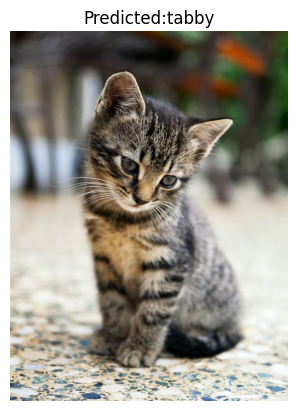

In [20]:
# show image and prediction
plt.imshow(img)
plt.title(f"Predicted:{labels}")
plt.axis('off')
plt.show()